In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
from iEEG_helper_functions import *

In [2]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes_new/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SOZ_DIR = "../../Data/seizure_onset_zones/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    # 160,
    # 172,
    # # 141, # not enough time before first seizure
    # 145,
    138,
    142,
    # 151,
    # 187,
    # 180,
    # 184,
    # 196,  # not enough time before first seizure
    # 204,  # not enough time before first seizure
    # 169,  # not enough time after the last seizure
    # 173,
    # 150,  # not enough time before first seizure
    # 207,  # not enough time before first seizure
    # 223,
    # 196,  # not enough time before first seizure
    # 204,  # not enough time before first seizure
    # 177,
    # 185,
    # 189,  # not enough time before first seizure
    # 205,  # not enough time before first seizure
    # 166,
    # 170,  # not enough time before first seizure
    # 174,  # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())
# Initialize a dataframe with hup_id, dataset_name, fs
patients_df = pd.DataFrame(columns=["hup_id", "dataset_name", "fs"])
for patient_hup_id in completed_hup_ids:
    dataset_name = f"HUP{patient_hup_id}_phaseII"
    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    fs = int(dataset.get_time_series_details(channel_labels_to_download[0]).sample_rate)
    # Construct a row and add it to the dataframe
    row_df = pd.DataFrame(
        [{"hup_id": patient_hup_id, "dataset_name": dataset_name, "fs": fs}]
    )
    patients_df = pd.concat([patients_df, row_df], ignore_index=True)
# Sort the dataframe by hup_id
patients_df = patients_df.sort_values(by="hup_id")
# reset the index
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,dataset_name,fs
0,138,HUP138_phaseII,1024
1,142,HUP142_phaseII,512


In [5]:
thresholds = [
    # 4.6,
    # 4,
    # 4,
    4.3,
    4,
    # 5.5,
    # 4.1,
    # 4,
    # 3.8,
    # 4,
    # 3.8,
    # 4.5,
    # 4,
    # 4,
    # 4,
    # 4,
    # 4,
    # 4,
    # 4,
    # 3.7,
    # 4,
    # 4,
    # 4,
    # 5,
    # 4,
    # 4,
]
thresholds = np.exp(thresholds)
thresholds, len(thresholds)

(array([73.6997937 , 54.59815003]), 2)

In [6]:
def format_channels(channel_array):
    formatted_array = []
    for label in channel_array:
        if label == "PZ":
            formatted_array.append(label)
            continue

        # Splitting string into two parts: prefix (letters) and number
        prefix, number = (
            label[: -len([ch for ch in label if ch.isdigit()])],
            label[-len([ch for ch in label if ch.isdigit()]) :],
        )

        # Formatting the number to have two digits
        formatted_number = f"{int(number):02}"

        # Appending prefix and formatted number
        formatted_label = prefix + formatted_number
        formatted_array.append(formatted_label)

    return np.array(formatted_array)

In [7]:
# def create_pwd_file(username, password, fname=None):
#     if fname is None:
#         fname = "{}_ieeglogin.bin".format(username[:3])
#     with open(fname, "wb") as f:
#         f.write(password.encode())
#     print("-- -- IEEG password file saved -- --")


# create_pwd_file("dma", "mycqEv-pevfo4-roqfan")
# print("Using Devin session")
# with open("dma_ieeglogin.bin", "r") as f:
#     session = Session("dma", f.read())
print("Using Carlos session")
with open("agu_ieeglogin.bin", "r") as f:
    session = Session("aguilac", f.read())

Using Carlos session


In [8]:
all_spikes_dfs = []
all_fs = []
for patient_index, row in patients_df.iterrows():
    patient_hup_id = row["hup_id"]
    fs = row["fs"]
    all_fs.append(fs)
    dataset_name = row["dataset_name"]

    print(f"Processing HUP {patient_hup_id} with fs {fs}")

    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    ###############################
    # Construct spike_files_df
    ###############################

    # Initialize an empty list to hold the data
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(SPIKES_OUTPUT_DIR):
        # Check if the file ends with .npy
        if filename.endswith(".npy"):
            # Use regular expression to match the pattern and extract desired numbers
            match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

            if match:
                current_patient_hup_id = int(match.group(1))
                if current_patient_hup_id != patient_hup_id:
                    continue
                interval_index = int(match.group(2))

                # Append the data to the list
                data.append(
                    {
                        "filename": filename,
                        "interval_index": interval_index,
                    }
                )

    # Convert the list of dictionaries to a pandas DataFrame
    spike_files_df = pd.DataFrame(data)
    # Sort the DataFrame by the interval index
    spike_files_df = spike_files_df.sort_values(by="interval_index")
    # Reset the index
    spike_files_df = spike_files_df.reset_index(drop=True)
    # Add a new column called "start_sample_index"
    spike_files_df["start_sample_index"] = (
        spike_files_df["interval_index"] * fs * 60 * 2
    )

    ###############################
    # Construct all_spikes_df
    ###############################
    # Initialize an empty list to store individual DataFrames
    dfs = []

    for index, row in spike_files_df.iterrows():
        filename = row["filename"]
        start_sample_index = row["start_sample_index"]

        # Load the data
        spike_data = np.load(
            os.path.join(SPIKES_OUTPUT_DIR, filename), allow_pickle=True
        )

        # Adjust the start_sample_index
        spike_data[:, 0] += start_sample_index

        # Convert the modified spike_data to a DataFrame and append to the dfs list
        dfs.append(
            pd.DataFrame(
                spike_data,
                columns=[
                    "peak_index",
                    "channel_index",
                    "channel_label",
                    "peak",
                    "left_point",
                    "right_point",
                    "slow_end",
                    "slow_max",
                    "rise_amp",
                    "decay_amp",
                    "slow_width",
                    "slow_amp",
                    "rise_slope",
                    "decay_slope",
                    "average_amp",
                    "linelen",
                ],
            )
        )

    # Concatenate all the individual DataFrames into a single DataFrame
    all_spikes_df = pd.concat(dfs, ignore_index=True)
    # Drop any rows with any NaN values
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)
    # Make peak_index and channel_index integers
    all_spikes_df["peak_index"] = all_spikes_df["peak_index"].astype(int)
    # Sort the DataFrame by peak_index
    all_spikes_df = all_spikes_df.sort_values(by="peak_index")
    # Reset the index
    all_spikes_df = all_spikes_df.reset_index(drop=True)
    # Add a column called peak_time_microseconds
    all_spikes_df["peak_time_microseconds"] = (
        all_spikes_df["peak_index"] / fs * 1e6
    ).astype(int)
    all_spikes_df["channel_index"] = all_spikes_df["channel_index"].astype(int)
    # Add a column called channel_label that indexes into channel_labels_to_download using channel_index
    all_spikes_df["channel_label_computed"] = format_channels(
        channel_labels_to_download
    )[all_spikes_df["channel_index"].values]
    # Drop the column peak	left_point	right_point	slow_end
    all_spikes_df = all_spikes_df.drop(
        columns=["peak", "left_point", "right_point", "slow_end"]
    )
    # Reset the index
    all_spikes_df = all_spikes_df.reset_index(drop=True)

    ###############################
    # ISI
    ###############################
    # Calculate the inter-spike interval
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

    # Drop the first row and reset index
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)

    # Convert the inter_spike_interval_samples column to integer
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
        "inter_spike_interval_samples"
    ].astype(int)

    ###############################
    # sequence_index
    ###############################
    print(f"this is for patient {patient_hup_id} with index {patient_index}")
    # Check for sequence change based on sequence_index or inter_spike_interval_samples
    change_mask = (
        all_spikes_df["inter_spike_interval_samples"] > thresholds[patient_index]
    )

    # Create the sequence_index_mask
    all_spikes_df["sequence_index"] = change_mask.astype(int).cumsum()

    ###############################
    # is_leader
    ###############################
    # Adding is_leader column
    all_spikes_df["is_leader"] = ~all_spikes_df["sequence_index"].duplicated(
        keep="first"
    )

    ###############################
    # is_soz
    ###############################
    # Add a column called is_soz and set it to true if the channel_label is in the soz list
    soz_channels = np.load(os.path.join(SOZ_DIR, f"HUP_{patient_hup_id}.npy"))
    all_spikes_df["is_soz"] = all_spikes_df["channel_label_computed"].isin(soz_channels)

    ###############################
    # Reorganize columns to the order of peak_index	channel_index inter_spike_interval_samples	sequence_index	is_leader slow_max	rise_amp	decay_amp	slow_width	slow_amp	rise_slope	decay_slope	average_amp	linelen
    ###############################
    all_spikes_df = all_spikes_df[
        [
            "peak_index",
            "peak_time_microseconds",
            "channel_index",
            "channel_label",
            "channel_label_computed",
            "is_soz",
            "inter_spike_interval_samples",
            "sequence_index",
            "is_leader",
            "slow_max",
            "rise_amp",
            "decay_amp",
            "slow_width",
            "slow_amp",
            "rise_slope",
            "decay_slope",
            "average_amp",
            "linelen",
        ]
    ]

    ###############################
    # Edit column names
    ###############################
    # Add "morphology_" prefix to slow_max	rise_amp	decay_amp	slow_width	slow_amp	rise_slope	decay_slope	average_amp	linelen

    all_spikes_df = all_spikes_df.rename(
        columns={
            "peak_index": "peak_index_samples",
            "slow_max": "morphology_slow_max",
            "rise_amp": "morphology_rise_amp",
            "decay_amp": "morphology_decay_amp",
            "slow_width": "morphology_slow_width",
            "slow_amp": "morphology_slow_amp",
            "rise_slope": "morphology_rise_slope",
            "decay_slope": "morphology_decay_slope",
            "average_amp": "morphology_average_amp",
            "linelen": "morphology_linelen",
        }
    )

    all_spikes_dfs.append(all_spikes_df)
    # Save the DataFrame to an csv file
    all_spikes_df.to_csv(
        f"../../Public/spikes/v2/HUP_{patient_hup_id}.csv", index=False
    )

Processing HUP 138 with fs 1024
this is for patient 138 with index 0
Processing HUP 142 with fs 512
this is for patient 142 with index 1


In [9]:
all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,channel_label_computed,is_soz,inter_spike_interval_samples,sequence_index,is_leader,morphology_slow_max,morphology_rise_amp,morphology_decay_amp,morphology_slow_width,morphology_slow_amp,morphology_rise_slope,morphology_decay_slope,morphology_average_amp,morphology_linelen
0,2277670,4448574218,1,LDA2,LDA02,True,1,0,True,567.578496,678.631176,1085.440587,53,567.578496,18.341383,-51.687647,1221.351469,2498.162056
1,2277672,4448578125,2,LDA3,LDA03,True,2,0,False,303.428144,1229.506769,1531.925675,50,303.428144,94.577444,-66.605464,1995.469606,3274.070374
2,2277677,4448587890,3,LDA4,LDA04,True,5,0,False,289.487718,1223.453626,1522.692725,87,289.487718,26.596818,-54.381883,1984.799988,3363.373641
3,2277695,4448623046,10,LDB3,LDB03,True,18,0,False,332.994208,818.581153,1177.735283,51,332.994208,-16.371623,43.619825,1407.448794,2797.299766
4,2277695,4448623046,12,LDB5,LDB05,True,0,0,False,310.679151,554.292807,702.597551,70,310.679151,29.173306,-27.022983,905.591583,1961.91623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708495,282744507,552235365234,2,LDA3,LDA03,True,394,164875,True,131.381848,488.344777,531.9223,58,131.381848,-61.043097,11.563528,754.305927,1272.095311
708496,282744508,552235367187,1,LDA2,LDA02,True,1,164875,False,684.785633,575.975519,980.43018,188,684.785633,-57.597552,11.812412,1066.19061,3205.905918
708497,282745884,552238054687,0,LDA1,LDA01,True,1376,164876,True,183.599873,798.992165,423.936718,132,183.599873,-44.388454,10.093731,1010.960524,1797.964738
708498,282746027,552238333984,3,LDA4,LDA04,True,143,164877,True,115.769491,212.348134,430.638096,60,115.769491,4.246963,-30.759864,427.667183,925.482733


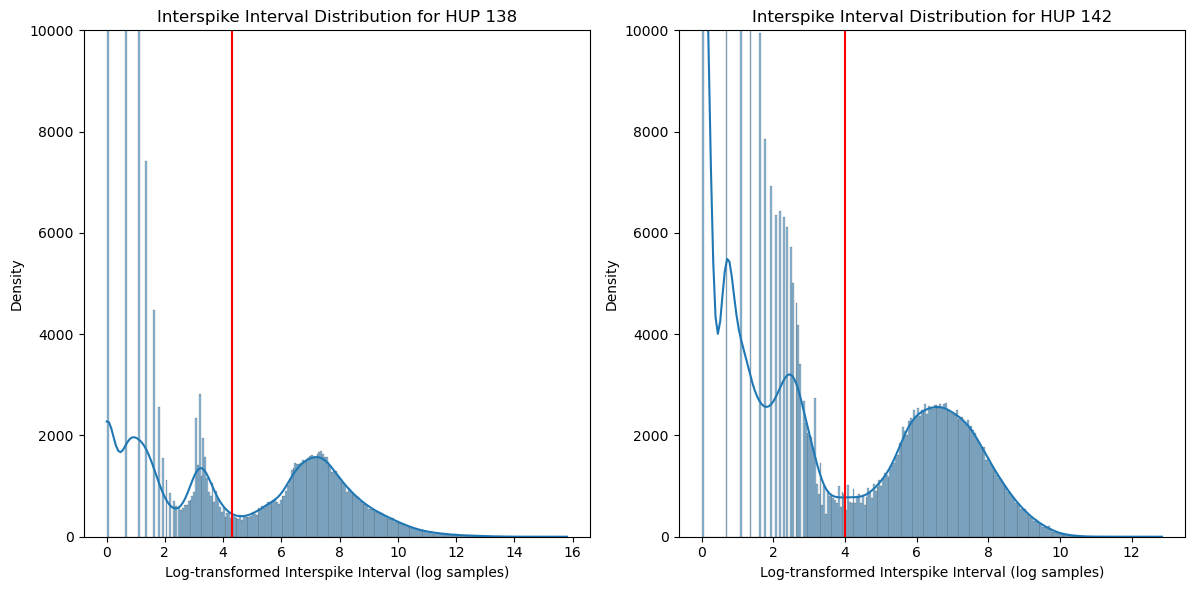

In [10]:
# Determine number of rows
num_plots = len(completed_hup_ids)
num_columns = 3
num_rows = (num_plots + 2) // num_columns  # ceil division

# Create a main figure and axes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 6 * num_rows))

# If there's only one row, axes is 1D and we should reshape it
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (hup_id, all_spikes_df) in enumerate(zip(completed_hup_ids, all_spikes_dfs)):
    # Find the row in patients_df that corresponds to the current hup_id
    patient_row = patients_df[patients_df["hup_id"] == hup_id]

    # Visualize with log transformation (excluding zeros to avoid -inf)
    log_data = np.log(
        all_spikes_df[all_spikes_df["inter_spike_interval_samples"] > 0][
            "inter_spike_interval_samples"
        ]
    )

    ax = axes[idx // num_columns, idx % num_columns]
    sns.histplot(log_data, kde=True, bins=250, ax=ax)
    # plot a vertical line at the threshold
    ax.axvline(np.log(thresholds[idx]), color="red", label="Threshold")
    ax.set_title(f"Interspike Interval Distribution for HUP {hup_id}")
    ax.set_xlabel("Log-transformed Interspike Interval (log samples)")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 10000)

# Remove any unused subplots
for idx in range(num_plots, num_rows * num_columns):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()